In [2]:
import pickle

import librosa.feature
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt
import tensorflow_decision_forests as tfdf

2023-05-18 11:00:08.756661: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Define Feature Extraction

In [3]:
def get_mfcc(y, sr):
    return np.array(librosa.feature.mfcc(y=y, sr=sr))


def get_mel_spectrogram(y, sr):
    return np.array(librosa.feature.melspectrogram(y=y, sr=sr))


def get_chroma_vector(y, sr):
    return np.array(librosa.feature.chroma_stft(y=y, sr=sr))


def get_tonnetz(y, sr):
    return np.array(librosa.feature.tonnetz(y=y, sr=sr))


def get_zero_crossings(y):
    return librosa.zero_crossings(y, pad=False)


def get_zero_crossing_rate(y):
    return librosa.feature.zero_crossing_rate(y)


def get_tempo(y, sr):
    onset_envelope = librosa.onset.onset_strength(y=y, sr=sr)
    prior_lognorm = scipy.stats.lognorm(loc=np.log(120), scale=120, s=1)
    return librosa.feature.tempo(
        onset_envelope=onset_envelope,
        sr=sr,
        aggregate=None,
        prior=prior_lognorm,
    )


def get_feature(y, sr):
    mfcc = get_mfcc(y, sr)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_min = mfcc.min(axis=1)
    mfcc_max = mfcc.max(axis=1)
    mfcc_feature = np.concatenate((mfcc_mean, mfcc_min, mfcc_max))

    mel_spectrogram = get_mel_spectrogram(y, sr)
    mel_spectrogram_mean = mel_spectrogram.mean(axis=1)
    mel_spectrogram_min = mel_spectrogram.min(axis=1)
    mel_spectrogram_max = mel_spectrogram.max(axis=1)
    mel_spectrogram_feature = np.concatenate((mel_spectrogram_mean, mel_spectrogram_min, mel_spectrogram_max))

    chroma = get_chroma_vector(y, sr)
    chroma_mean = chroma.mean(axis=1)
    chroma_min = chroma.min(axis=1)
    chroma_max = chroma.max(axis=1)
    chroma_feature = np.concatenate((chroma_mean, chroma_min, chroma_max))

    tonnetz = get_tonnetz(y, sr)
    tonnetz_mean = tonnetz.mean(axis=1)
    tonnetz_min = tonnetz.min(axis=1)
    tonnetz_max = tonnetz.max(axis=1)
    tonnetz_feature = np.concatenate((tonnetz_mean, tonnetz_min, tonnetz_max))

    zero_crossing_rate = get_zero_crossing_rate(y)
    zero_crossing_rate_mean = zero_crossing_rate.mean(axis=1)
    zero_crossing_rate_min = zero_crossing_rate.min(axis=1)
    zero_crossing_rate_max = zero_crossing_rate.max(axis=1)
    zero_crossing_feature = np.concatenate((
        zero_crossing_rate_mean,
        zero_crossing_rate_min,
        zero_crossing_rate_max
    ))

    tempo = get_tempo(y, sr)
    tempo_mean = tempo.mean()
    tempo_min = tempo.min()
    tempo_max = tempo.max()
    tempo_feature = np.array([tempo_mean, tempo_min, tempo_max])

    return np.concatenate((
        chroma_feature,
        mel_spectrogram_feature,
        mfcc_feature,
        tonnetz_feature,
        zero_crossing_feature,
        tempo_feature
    ))

## Make Training Data

In [4]:
def make_training_data():
    with open('../pickles/processed_data.pkl', 'rb') as f:
        data = pickle.load(f)
    xs = []
    ys = []
    for label, y, sr in data:
        features = get_feature(y, sr)
        xs.append(features)
        ys.append(label)
    xs = np.array(xs)
    ys = np.array(ys)
    print(xs.shape)
    print(ys.shape)
    permutations = np.random.permutation(999)
    features = np.array(xs)[permutations]
    labels = np.array(ys)[permutations]
    features_train = features[0:900]
    labels_train = labels[0:900]
    features_test = features[900:999]
    labels_test = labels[900:999]
    data_set = (
        (labels_train, features_train),
        (labels_test, features_test)
    )
    with open('data_set.pkl', 'wb') as f:
        pickle.dump(data_set, f)

In [5]:
make_training_data()

(999, 504)
(999,)


## Define Training Data Loader

In [6]:
def load_data():
    with open('data_set.pkl', 'rb') as f:
        data_set = pickle.load(f)

    return data_set

## Define Build Model, Train and Evaluate Model

In [7]:
def build_model():
    """
    https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
    """

    model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)
    model.compile(metrics=["accuracy"])

    return model


def train(model, data_set):
    return model.fit(
        x=data_set[0][1].tolist(),
        y=data_set[0][0].tolist(),
    )


def evaluate_model(model, data_set):
    return model.evaluate(x=data_set[1][1].tolist(), y=data_set[1][0].tolist(), return_dict=True)


## Load Training Data

In [8]:
data_set = load_data()

## Build Model

In [9]:
model = build_model()

Use /var/folders/kr/_kzfl2bd0_b4qw4dj2c4l_x00000gn/T/tmpflh3b4lh as temporary training directory


## Train

In [10]:
history = train(model, data_set)

Reading training dataset...
Training dataset read in 0:00:10.498991. Found 900 examples.
Training model...


[INFO 23-05-18 11:11:29.5362 BST kernel.cc:1242] Loading model from path /var/folders/kr/_kzfl2bd0_b4qw4dj2c4l_x00000gn/T/tmpflh3b4lh/model/ with prefix db8b55ffaa0c4506


Model trained in 0:00:01.529227
Compiling model...


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

[INFO 23-05-18 11:11:29.8288 BST decision_forest.cc:660] Model loaded with 300 root(s), 59348 node(s), and 494 input feature(s).
[INFO 23-05-18 11:11:29.8290 BST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-05-18 11:11:29.8291 BST kernel.cc:1074] Use fast generic engine
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Model compiled.


## Evaluate

In [11]:
evaluation = evaluate_model(model, data_set)

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 6s 5ms/step - loss: 0.0000e+00 - accuracy: 0.6162
loss: 0.0000
accuracy: 0.6162


## Plot Accuracy and Loss

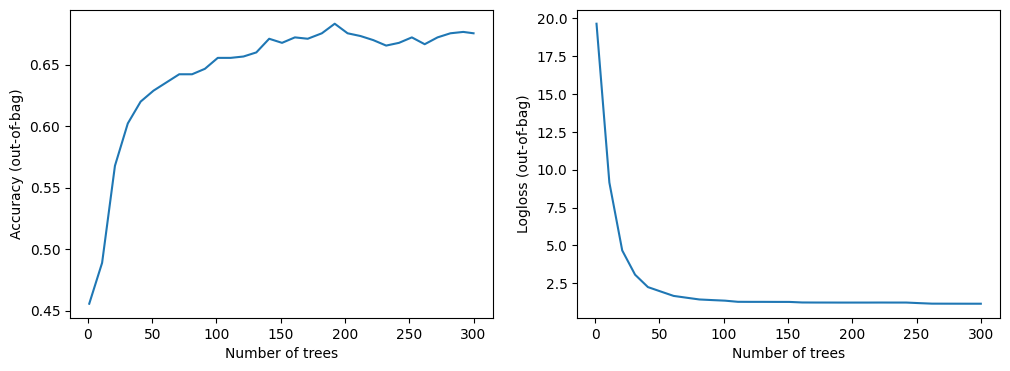

In [12]:
logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

## Save Model

In [15]:
model.save('../saved_models/random_forest_1')

INFO:tensorflow:Assets written to: ../saved_models/random_forest_1/assets


INFO:tensorflow:Assets written to: ../saved_models/random_forest_1/assets
